## Import Dataset and Basic Setup

In [1]:
import torch
import json
import os

from torchvision.transforms import ToTensor
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data.dataloader import *
img_to_tensor = ToTensor()

import time
import copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2021-05-09 00:01:17--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  12.0MB/s    in 28s     

2021-05-09 00:01:46 (8.30 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [3]:
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200

test  train  val  wnids.txt  words.txt


In [4]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ])
}

data_dir = 'tiny-imagenet-200/'
num_workers = {
    'train' : 100,
    'val'   : 0,
    'test'  : 0
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=2,
                                             shuffle=True, num_workers=num_workers[x])
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fa5e86cb5d0>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fa5e86dd250>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fa63fabd910>}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


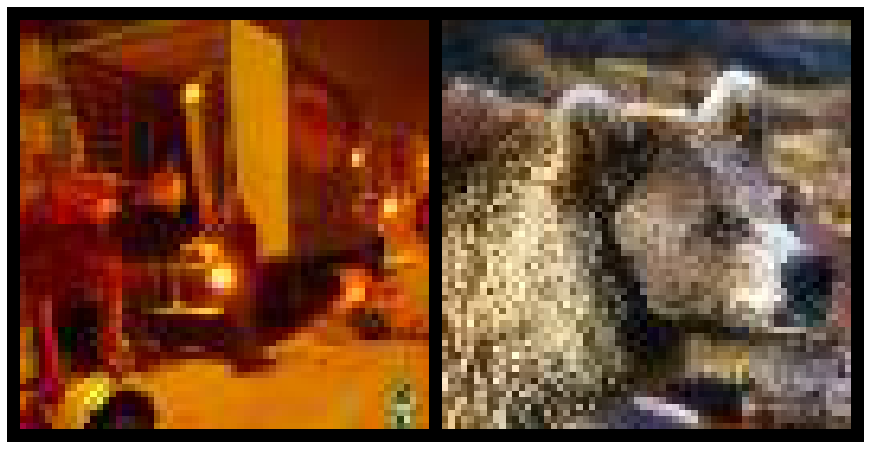

In [8]:
from torchvision.utils import make_grid

for images, _ in dataloaders['train']:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

#### The SIMCLR model

Reference: 
https://github.com/leftthomas/SimCLR

In [9]:
# model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import resnet50


class Model(nn.Module):
    def __init__(self, feature_dim=128):
        super(Model, self).__init__()

        self.f = []
        for name, module in resnet50().named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.f.append(module)
        # encoder
        self.f = nn.Sequential(*self.f)
        # projection head
        self.g = nn.Sequential(nn.Linear(2048, 512, bias=False), nn.BatchNorm1d(512),
                               nn.ReLU(inplace=True), nn.Linear(512, feature_dim, bias=True))

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        return F.normalize(feature, dim=-1), F.normalize(out, dim=-1)

In [10]:
!pip install thop

In [11]:
# main.py
import argparse
import os

import pandas as pd
import torch
import torch.optim as optim
from thop import profile, clever_format
from torch.utils.data import DataLoader
from tqdm import tqdm



In [12]:
# train for one epoch to learn unique features
def train(net, data_loader, train_optimizer):
    net.train()
    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
    train_loss = []

    for pos, labels in train_bar:

        pos = pos.cuda()

        feature_1, out_1 = net(pos.view(-1,3, 64, 64).cuda())
        feature_2, out_2 = net(pos.view(-1,3, 64, 64).cuda())
        # [2*B, D]
        out = torch.cat([out_1, out_2], dim=0)
        # [2*B, 2*B]
        sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
        mask = (torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=sim_matrix.device)).bool()
        # [2*B, 2*B-1]
        sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)

        # compute loss
        pos_sim = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
        # [2*B]
        pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
        loss = (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean()
        train_loss.append(loss.cpu().data.item())
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += batch_size
        total_loss += loss.item() * batch_size
        train_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f}'.format(epoch, epochs, total_loss / total_num))

    return total_loss / total_num, train_loss

In [13]:
# test for one epoch, use weighted knn to find the most similar images' label to assign the test image
def test(net, memory_data_loader, test_data_loader):
    net.eval()
    test_loss=[]
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data,  target in tqdm(memory_data_loader, desc='Feature extracting'):
            feature, out = net(data.cuda(non_blocking=True))
            feature_bank.append(feature)
            #print(target)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data,  target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature, out = net(data)
            total_num += data.size(0)
            # [B, N]
            sim_matrix = torch.mm(feature, feature_bank)
            # [B, K]
            sim_weight, sim_indices = sim_matrix.topk(k=k, dim=-1)
            # [B, K]
            sim_labels = torch.gather(feature_labels.expand(data.size(0), -1), dim=-1, index=sim_indices)
            sim_weight = (sim_weight / temperature).exp()

            # counts for each class
            one_hot_label = torch.zeros(data.size(0) * k, c, device=sim_labels.device)
            # [B*K, C]
            one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
            # weighted score ---> [B, C]
            pred_scores = torch.sum(one_hot_label.view(data.size(0), -1, c) * sim_weight.unsqueeze(dim=-1), dim=1)

            pred_labels = pred_scores.argsort(dim=-1, descending=True)
            total_top1 += torch.sum((pred_labels[:, :1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_top5 += torch.sum((pred_labels[:, :5] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}% Acc@5:{:.2f}%'
                                     .format(epoch, epochs, total_top1 / total_num * 100, total_top5 / total_num * 100))

    return total_top1 / total_num * 100, total_top5 / total_num * 100

#### Training in 1 epoch

In [ ]:
batch_size =2
if __name__ == '__main__':
    
    import easydict
    args = easydict.EasyDict({
        "feature_dim":128,
        "temperature": 0.5,
        "k": 200,
        "barch_size": 2,
        "epochs": 10
    })

    train_loader = dataloaders['train']
    memory_loader = dataloaders['train']
    test_loader = dataloaders['val']

    model = Model(128).cuda()
    flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).cuda(),))
    flops, params = clever_format([flops, params])
    print('# Model Params: {} FLOPs: {}'.format(params, flops))
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
    c =200 

    # training loop
    best_acc = 0.0
    epochs =1
    temperature =0.5
    k = 200
    feature_dim = 128
    barch_size =2
    results = {'train_loss': [], 'test_acc@1': [], 'test_acc@5': []}
    save_name_pre = '{}_{}_{}_{}_{}'.format(feature_dim, temperature, k, batch_size, epochs)
    if not os.path.exists('results'):
        os.mkdir('results')
    losses =[]
    for epoch in range(1, epochs + 1):
        train_loss, train_losses = train(model, train_loader, optimizer)
        losses.extend(train_losses)
        results['train_loss'].append(train_loss)
        test_acc_1, test_acc_5 = test(model, memory_loader, test_loader)
        results['test_acc@1'].append(test_acc_1)
        results['test_acc@5'].append(test_acc_5)
        # save statistics
        data_frame = pd.DataFrame(data=results, index=range(1, epoch + 1))
        data_frame.to_csv('results/{}_statistics.csv'.format(save_name_pre), index_label='epoch')
        if test_acc_1 > best_acc:
            best_acc = test_acc_1
            torch.save(model.state_dict(), 'results/{}_model.pth'.format(save_name_pre))
        np.savez('results/data.npz', train_loss = losses)

  0%|          | 0/50000 [00:00<?, ?it/s]

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torchvision.models.resnet.Bottleneck'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[WARN] Cannot find rule for <class '__main__.Model'>. Treat it as zero Macs and zero Params.
# Model Params: 24.62M FLOPs: 1.31G


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Test Epoch: [1/1] Acc@1:0.41% Acc@5:2.17%: 100%|██████████| 5000/5000 [01:09<00:00, 71.50it/s]


In [ ]:
torch.save(model.state_dict(), 'simclr_entire.pth')

#### Training in 5 epoches

In [14]:
batch_size =2
if __name__ == '__main__':
    
    import easydict
    args = easydict.EasyDict({
        "feature_dim":128,
        "temperature": 0.5,
        "k": 200,
        "barch_size": 2,
        "epochs": 10
    })

    train_loader = dataloaders['train']
    memory_loader = dataloaders['train']
    test_loader = dataloaders['val']

    model = Model(128).cuda()
    flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).cuda(),))
    flops, params = clever_format([flops, params])
    print('# Model Params: {} FLOPs: {}'.format(params, flops))
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
    c =200 

    # training loop
    best_acc = 0.0
    epochs =5
    temperature =0.5
    k = 200
    feature_dim = 128
    barch_size =2
    results = {'train_loss': [], 'test_acc@1': [], 'test_acc@5': []}
    save_name_pre = '{}_{}_{}_{}_{}'.format(feature_dim, temperature, k, batch_size, epochs)
    if not os.path.exists('results'):
        os.mkdir('results')
    losses =[]
    for epoch in range(1, epochs + 1):
        train_loss, train_losses = train(model, train_loader, optimizer)
        losses.extend(train_losses)
        results['train_loss'].append(train_loss)
        test_acc_1, test_acc_5 = test(model, memory_loader, test_loader)
        results['test_acc@1'].append(test_acc_1)
        results['test_acc@5'].append(test_acc_5)
        # save statistics
        data_frame = pd.DataFrame(data=results, index=range(1, epoch + 1))
        data_frame.to_csv('results/{}_statistics.csv'.format(save_name_pre), index_label='epoch')
        if test_acc_1 > best_acc:
            best_acc = test_acc_1
            torch.save(model.state_dict(), 'results/{}_model.pth'.format(save_name_pre))
        np.savez('results/data2.npz', train_loss = losses)

  0%|          | 0/50000 [00:00<?, ?it/s]

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torchvision.models.resnet.Bottleneck'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[WARN] Cannot find rule for <class '__main__.Model'>. Treat it as zero Macs and zero Params.
# Model Params: 24.62M FLOPs: 1.31G


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Test Epoch: [5/5] Acc@1:0.62% Acc@5:2.71%: 100%|██████████| 5000/5000 [00:59<00:00, 83.41it/s]


In [15]:
torch.save(model.state_dict(), 'simclr_entire.pth')